<a href="https://colab.research.google.com/github/souken-b/calc_OWC/blob/main/cal_pulating_pres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
T = 20
n = 1000
n_diam = 0.8123 / 100
d_ratio = n_diam / (25.4 / 1000)
A0 = np.pi * (((25.4 / 2) / (1000)) ** 2)
L = 120 / 1000
L0 = 158.3 / 1000
p_air = 101325 
p_0 = 500 + p_air
n_ratio = d_ratio ** 2
A = A0 * n_ratio
h_ratio = 1.4
dens_air = 1.225

In [44]:
def c_ci(d_ratio: 'diameter ratiodiameter'):
  # flow coefficient
  f_coef = 0.598 - 0.003 * (d_ratio ** 2) + 0.404 * (d_ratio ** 4)
  return (f_coef / ((1 + (d_ratio ** 4) * (f_coef ** 2)) ** (1/2)))

In [45]:
def force_ci(c_ci: '縮流係数'):
  return ((1 / c_ci) - (1 / (2 * (c_ci ** 2))))

In [46]:
def c_c(f_ci: 'force coef', p_up, p_air, h_ratio):
  p_ratio = p_up / p_air
  h_ratio_rev = 1/ h_ratio
  return ((1 / (2 * f_ci)) * (p_ratio ** h_ratio_rev) * (1 - (1 - ((2 * f_ci * (1 - h_ratio_rev)) * (1 - (1 / p_ratio)) / (1- (p_ratio) ** (h_ratio_rev - 1))))  ** (1/2)))

In [47]:
def rounge_kutta(n, T, dpdt, p_0, p_air, d_ratio, h_ratio, A0, L, L0, A, c_ci, c_c, f_ci, forward_flow):
  h = T / n
  t = np.arange(0, T, h)
  p = np.empty(n)
  p[0] = p_0
  
  # 方程式を解くための反復計算
  for i in range(n-1):
    k_1 = h * dpdt(p[i], p_air, t[i], T, d_ratio, h_ratio, A0, L, L0, A, c_ci, c_c, f_ci, forward_flow)
    k_2 = h * dpdt(p[i] + k_1 /2 , p_air, t[i] + h/2, T, d_ratio, h_ratio, A0, L, L0, A, c_ci, c_c, f_ci, forward_flow)
    k_3 = h * dpdt(p[i] + k_2 /2 , p_air, t[i] + h/2, T, d_ratio, h_ratio, A0, L, L0, A, c_ci, c_c, f_ci, forward_flow)
    k_4 = h * dpdt(p[i] + k_3, p_air, t[i] + h, T, d_ratio, h_ratio, A0, L, L0, A, c_ci, c_c, f_ci, forward_flow)
    p[i+1] = p[i] + 1/6 * (k_1 + 2*k_2 + 2*k_3 + k_4)
  
  # 誤差の計算
  v = np.empty(n)
  for i in range(n):
    v[i] = np.exp(h*i)
  e = v - p 
  
  return [t, p]

In [48]:
def forward_flow(c_c_c, n_area, p_up, p_air, h_ratio, dens_up):
  h_ratio_rev = 1 / h_ratio
  forward_flow =  c_c_c * n_area  * ((p_up / p_air) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_up / dens_up) * (1 - (p_up / p_air) ** (h_ratio_rev - 1))) ** (1 / 2))
  return forward_flow

In [49]:
def dpdt(p_up, p_air, t, T, d_ratio, h_ratio, A0, L, L0, A, c_ci, c_c, f_ci, forward_flow):
  c_freq = 2 * np.pi / T
  h_ratio_rev = 1 / h_ratio
  dens_up = 1.225 * ((p_up / p_air) ** (h_ratio_rev))
  n_ratio = d_ratio ** 2
  c_ci_c = c_ci(d_ratio)
  f_ci_c = f_ci(c_ci_c)
  c_c_c = c_c(f_ci_c, p_up, p_air, h_ratio)
  flow = forward_flow(c_c_c, n_ratio, p_up, p_air, h_ratio, dens_up)
  dpdt = (-7/5) * p_up * ((L * c_freq * np.cos(c_freq * t) / (L * np.sin(c_freq * t) - L0)) + ((p_air / p_up) ** (h_ratio_rev)) * (flow / ((L0 - L * np.sin(c_freq * t)) / A0)))
  return dpdt

In [50]:
t_r_list, p_r_list = rounge_kutta(n, T, dpdt, p_0, p_air, d_ratio, h_ratio, A0, L, L0, A, c_ci, c_c, force_ci, forward_flow)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


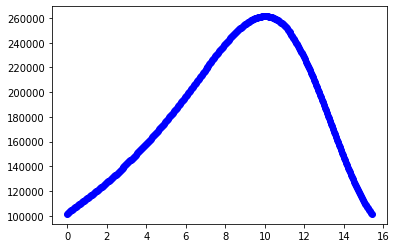

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_r_list, p_r_list, c='blue')
plt.show()

In [52]:
p_r_diff_list = p_r_list - p_air

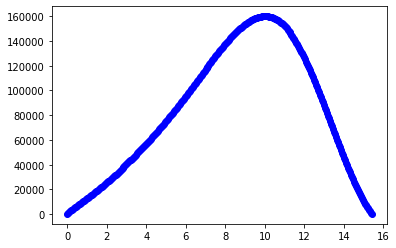

In [53]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_r_list, p_r_diff_list, c='blue')
plt.show()